In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import sys
import copy
import cobra
import cobra.test
import math
from collections import defaultdict
import efmtool
import matplotlib.pyplot as plt

### Define functions:

In [2]:
def convert_to_irreversible(cobra_model):
    """
    Split reversible reactions into two irreversible reactions

    These two reactions will proceed in opposite directions. This
    guarentees that all reactions in the model will only allow
    positive flux values, which is useful for some modeling problems.

    cobra_model:
        A cobra model object which will be modified in place.

    """
    from cobra import Reaction
    import pandas as pd
    from cobra.util import set_objective
    reactions_to_add = []
    coefficients = {}
    for reaction in cobra_model.reactions:
        # If a reaction is reverse only, the forward reaction (which
        # will be constrained to 0) will be left in the model.
        if reaction.lower_bound < 0:
            reverse_reaction = Reaction(reaction.id + "_b")
            reaction.id = reaction.id + "_f"
            reverse_reaction.lower_bound = max(0, -reaction.upper_bound)
            reverse_reaction.upper_bound = -reaction.lower_bound
            coefficients[reverse_reaction] = reaction.objective_coefficient * -1
            reaction.upper_bound = max(0, reaction.upper_bound)
            reaction.lower_bound = max(0, reaction.lower_bound)

            # Make the directions aware of each other
            reaction.notes["reflection"] = reverse_reaction.id
            reverse_reaction.notes["reflection"] = reaction.id
            reaction_dict = {k: v * -1 for k, v in pd.Series.iteritems(reaction._metabolites)}
            reverse_reaction.add_metabolites(reaction_dict)
            reverse_reaction._model = reaction._model
            reverse_reaction._genes = reaction._genes
            for gene in reaction._genes:
                gene._reaction.add(reverse_reaction)
            reverse_reaction.subsystem = reaction.subsystem
            #reverse_reaction._gene_reaction_rule = reaction._gene_reaction_rule
            #
            # ALO edited previous line as
            #
            reverse_reaction._gene_reaction_rule = reaction.gene_reaction_rule
            reactions_to_add.append(reverse_reaction)
    cobra_model.add_reactions(reactions_to_add)
    set_objective(cobra_model, coefficients, additive=True)
    return cobra_model

In [3]:
def MinNW(model,protected_mets,protected_rxns,functionality_df):
    '''
    A MILP formulation derived from (https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1412-z) to
    reduce a Genome-Scale Metabolic Network so that EFM calculation is faster and macroreactions may be derived. This is 
    an approach that InSilico uses. I want to make sure that it works for my stuff as well. 
    This is the second MILP, MinNW, that finds the smallest network it can given a model and specific functionalities. 
    
    Inputs:
        model: A cobra genome-scale metabolic model
        protected_mets: A list of protected metabolites, i.e. metabolites that absolutely need to be in the resulting network
        
        protected_rxns: A list of protected reactions, i.e. reactions that absolutely need to be in the resulting network
        
        functionality_df: A (Fx3) pandas DataFrame containing the reactions along with their lower and upper bounds describing 
            the F functionalities desired in the resulting network. May be opposing ones (e.g. O2 uptake inhibited and allowed).
            The first column contains the name of the reactions of interest, the second contains the lower bound and third
            the upper bound for the reaction. May contain more than one reaction. Needs to contain an equivalent amount of bonds. 
        
    Outputs:
        prob.status: Status of solver, either 'infeasible' or 'optimal'
        
        model_dict: A dictionary containing the Stoichiometric matrix, reactions, metabolites and bounds for the new, reduced 
            network. 
    
    '''
    import cvxpy as cp
    import cvxopt
    from cvxopt import solvers
    import cobra
    import itertools
    
    A = cobra.util.array.create_stoichiometric_matrix(model,'dense')
    b = np.zeros(A.shape[0])
    rxns = [rxn.id for rxn in model.reactions]
    n_rxns = len(rxns)
    n_mets = A.shape[0]
    n_functions = functionality_df.shape[0]
    lb = [rxn.lower_bound for rxn in model.reactions]
    ub = [rxn.upper_bound for rxn in model.reactions]
    #M = max(ub)
    M = np.array([ub]).T
    #print(M.shape)
    delta = 1e-6 # Between 1e-4 and 1e-6
    #delta = np.array([lb]).T # Between 1e-4 and 1e-6
    
    # Initiate an id_protected_rxns list:
    protected_rxns_orig = list(itertools.chain.from_iterable(protected_rxns))
    protected_met_rxns = []
    for met in protected_mets:
        protected_met_rxns_tmp = find_rxns_from_mets(model,met)
        if bool(set(protected_rxns_orig) & set(protected_met_rxns_tmp)):
            continue
        else:
            protected_met_rxns.append(protected_met_rxns_tmp)
    protected_met_rxns = list(set(list(itertools.chain.from_iterable(protected_met_rxns))))
    
    # Set constraints so that reactions associated with protected metabolites have at least 
    # an alpha of 1:
    id_met_rxn_protected = []
    for rxn in protected_met_rxns:
        id_met_rxn_protected.append(rxns.index(rxn))
    prot_met_vec = np.zeros(n_rxns)
    prot_met_vec[np.array(id_met_rxn_protected)] = 1
    
    id_rxn_protected = []
    for rxn in protected_rxns:
        id_rxn_protected.append(rxns.index(rxn))
    prot_rxn_vec = np.zeros(n_rxns)
    prot_rxn_vec[np.array(id_rxn_protected)] = 1
    
    # Add constraints to a matrix instead of multiple dictionaries:
    alpha_output = cp.Variable(n_rxns,boolean=True)
    alpha_orig = cp.Variable((n_rxns,n_functions),boolean=True) # Create a matrix of unknown alphas.
    v_vector_orig = cp.Variable((n_rxns,n_functions)) # Create a matrix of unknown fluxes.
    
    # Set upper and lower matrices:
    lb_mat = np.array(([lb]*n_functions)).T
    ub_mat = np.array(([ub]*n_functions)).T
    
    # Set bounds according to input df:
    for j in range(0,n_functions):
        # Get id of reactions in function first column:
        id_vec_tmp = [rxns.index(x) for x in functionality_df.iloc[j,0]]
        lb_mat[id_vec_tmp,j] = functionality_df.iloc[j,1]
        ub_mat[id_vec_tmp,j] = functionality_df.iloc[j,2]
    
    # Set the steady-state conditions:
    b_mat = np.zeros((n_functions,n_mets)).T
    
    # Set the inequalities:
    my_constraints = []
    my_constraints.append(A @ v_vector_orig == b_mat)
    my_constraints.append(v_vector_orig >= lb_mat)
    my_constraints.append(v_vector_orig <= ub_mat)
    my_constraints.append(delta*alpha_orig <= v_vector_orig)
    #my_constraints.append(0 <= v_vector_orig)
    my_constraints.append(v_vector_orig <= cp.multiply(alpha_orig,M))
    #my_constraints.append(v_vector_orig <= alpha_orig*M)
    
    # Add the protected reaction constraints:
    my_constraints.append(cp.sum(cp.multiply(prot_rxn_vec,alpha_output)) == len(id_rxn_protected))
    
    # Add the protected metabolite constraints:
    my_constraints.append(cp.sum(cp.multiply(prot_met_vec,alpha_output)) >= 1)
    
    # Calculate the sum of alphas:
    alpha_sum = cp.sum(alpha_orig, axis=1, keepdims=False)
    my_constraints.append(alpha_output <= alpha_sum)
    my_constraints.append(alpha_sum <= (1+n_functions)*alpha_output)
    
    # Solve!
    prob = cp.Problem(cp.Minimize(cp.sum(alpha_output)),constraints=my_constraints)
    #prob.solve(solver = 'GLPK_MI')
    prob.solve(solver = 'CPLEX')
    
    # Output a new model (S-matrix):
    id_present_reactions = np.where(alpha_output.value)
    A2 = A.T[id_present_reactions].T
    id_metabolites_present = np.where(A2.any(axis=1))[0]
    A_new = np.delete(A2, np.where(~A2.any(axis=1))[0], 0)
    
    # Output new lbs, ubs, rxns and metabolites for the model:
    lb_new = list(np.array(lb)[id_present_reactions])
    ub_new = list(np.array(ub)[id_present_reactions])
    rxns_new = list(np.array(rxns)[id_present_reactions])
    metabolites = [met.id for met in model.metabolites]
    metabolites_new = list(np.array(metabolites)[id_metabolites_present])
    
    # Output a model as dictionary:
    model_dict = defaultdict()
    model_dict['A'] = A_new
    model_dict['rxns'] = rxns_new
    model_dict['mets'] = metabolites_new
    model_dict['ub'] = ub_new
    model_dict['lb'] = lb_new
    
    return prob.status,model_dict

In [4]:
def MinNW_iterative(model,protected_mets,protected_rxns,functionality_df):
    '''
    An iterative MILP formulation derived from (https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1412-z) 
    to reduce a Genome-Scale Metabolic Network so that EFM calculation is faster and macroreactions may be derived. This is 
    an approach that InSilico uses. I want to make sure that it works for my stuff as well. 
    This is the third MILP, MinNW_iterative, that finds all the smallest network it can given a model and specific 
    functionalities. It goes through the process iteratively until all the smallest subnetworks are found. 
    
    Inputs:
        model: A cobra genome-scale metabolic model
        protected_mets: A list of protected metabolites, i.e. metabolites that absolutely need to be in the resulting network
        
        protected_rxns: A list of protected reactions, i.e. reactions that absolutely need to be in the resulting network
        
        functionality_df: A (Fx3) pandas DataFrame containing the reactions along with their lower and upper bounds describing 
            the F functionalities desired in the resulting network. May be opposing ones (e.g. O2 uptake inhibited and allowed).
            The first column contains the name of the reactions of interest, the second contains the lower bound and third
            the upper bound for the reaction. May contain more than one reaction. Needs to contain an equivalent amount of bonds. 
        
    Outputs:
        alpha_matrix: A (n_rxns x n_subnetworks) boolean matrix indicating which reactions are present in all the 
        resulting reduced networks. 
    
    '''
    import cvxpy as cp
    import cvxopt
    import cobra
    import itertools
    
    A = cobra.util.array.create_stoichiometric_matrix(model,'dense')
    b = np.zeros(A.shape[0])
    rxns = [rxn.id for rxn in model.reactions]
    n_rxns = len(rxns)
    n_mets = A.shape[0]
    n_functions = functionality_df.shape[0]
    lb = [rxn.lower_bound for rxn in model.reactions]
    ub = [rxn.upper_bound for rxn in model.reactions]
    #M = max(ub)
    M = np.array([ub]).T
    #print(M.shape)
    delta = 1e-6 # Between 1e-4 and 1e-6
    #delta = np.array([lb]).T # Between 1e-4 and 1e-6
    
    # Initiate an id_protected_rxns list:
    protected_rxns_orig = list(itertools.chain.from_iterable(protected_rxns))
    protected_met_rxns = []
    for met in protected_mets:
        protected_met_rxns_tmp = find_rxns_from_mets(model,met)
        if bool(set(protected_rxns_orig) & set(protected_met_rxns_tmp)):
            continue
        else:
            protected_met_rxns.append(protected_met_rxns_tmp)
    protected_met_rxns = list(set(list(itertools.chain.from_iterable(protected_met_rxns))))
    
    # Set constraints so that reactions associated with protected metabolites have at least 
    # an alpha of 1:
    id_met_rxn_protected = []
    for rxn in protected_met_rxns:
        id_met_rxn_protected.append(rxns.index(rxn))
    prot_met_vec = np.zeros(n_rxns)
    prot_met_vec[np.array(id_met_rxn_protected)] = 1
    
    id_rxn_protected = []
    for rxn in protected_rxns:
        id_rxn_protected.append(rxns.index(rxn))
    prot_rxn_vec = np.zeros(n_rxns)
    prot_rxn_vec[np.array(id_rxn_protected)] = 1
    
    # Set upper and lower matrices:
    lb_mat = np.array(([lb]*n_functions)).T
    ub_mat = np.array(([ub]*n_functions)).T
    
    # Set bounds according to input df:
    for j in range(0,n_functions):
        # Get id of reactions in function first column:
        id_vec_tmp = [rxns.index(x) for x in functionality_df.iloc[j,0]]
        lb_mat[id_vec_tmp,j] = functionality_df.iloc[j,1]
        ub_mat[id_vec_tmp,j] = functionality_df.iloc[j,2]
    
    # Set the steady-state conditions:
    b_mat = np.zeros((n_functions,n_mets)).T
    
    curr_status = 1
    k = 0
    alpha_list = []
    while curr_status == 1:
        # Set the inequalities:
        alpha_output = cp.Variable(n_rxns, boolean = True)
        alpha_orig = cp.Variable((n_rxns,n_functions),boolean = True) # Create a matrix of unknown alphas.
        v_vector_orig = cp.Variable((n_rxns,n_functions)) # Create a matrix of unknown fluxes.
        my_constraints = []
        my_constraints.append(A @ v_vector_orig == b_mat)
        my_constraints.append(v_vector_orig >= lb_mat)
        my_constraints.append(v_vector_orig <= ub_mat)
        my_constraints.append(delta*alpha_orig <= v_vector_orig)
        #my_constraints.append(0 <= v_vector_orig)
        my_constraints.append(v_vector_orig <= cp.multiply(alpha_orig,M))
        #my_constraints.append(v_vector_orig <= alpha_orig*M)

        # Add the protected reaction constraints:
        my_constraints.append(cp.sum(cp.multiply(prot_rxn_vec,alpha_output)) == len(id_rxn_protected))

        # Add the protected metabolite constraints:
        my_constraints.append(cp.sum(cp.multiply(prot_met_vec,alpha_output)) >= 1)

        # Calculate the sum of alphas:
        alpha_sum = cp.sum(alpha_orig, axis=1, keepdims=False)
        my_constraints.append(alpha_output <= alpha_sum)
        my_constraints.append(alpha_sum <= (1+n_functions)*alpha_output)

        # Add the iterative Z constraint:
        if k != 0:
            #print(cp.sum(cp.multiply(1-Z),alpha_output))
            my_constraints.append(cp.sum(cp.multiply((1-np.array(Z)),alpha_output)) + cp.sum(cp.multiply(np.array(Z),(1-alpha_output))) >= 1)
            #my_constraints.append(cp.sum(alpha_output) == np.sum(Z))
        # Solve!
        prob = cp.Problem(cp.Minimize(cp.sum(alpha_output)),constraints=my_constraints)
        #prob.solve(solver = 'GLPK_MI',options=["--tmlim", "10","--interior"])
        prob.solve(solver = 'CPLEX')

        if prob.status == 'optimal':
            #if k != 0:
                #print(np.sum(alpha_output.value-Z))
            Z = alpha_output.value.tolist()
            if Z in alpha_list:
                curr_status = 0
                #break
            else:
                alpha_list.append(Z)
                curr_status = 1
                k += 1
        else:
            curr_status = 0
            
    return alpha_list

In [5]:
def new_model_FBA(model_dict,objective_reaction):
    import cobra
    import cvxpy as cp
    import cvxopt
    import numpy as np
    
    A_new = model_dict['A']
    lb_new = model_dict['lb']
    ub_new = model_dict['ub']
    rxns_new = model_dict['rxns']
    n_rxns = len(rxns_new)
    id_c = rxns_new.index(objective_reaction)
    c = np.zeros(A_new.shape[1])
    c[id_c] = -1 
    lb_obj = model_dict['lb'][id_c]
    ub_obj = model_dict['ub'][id_c]
    
     # Steady-state constraints
    b = np.zeros(A_new.shape[0])
    
    # Create optimization problem:
    flux_vector = cp.Variable(n_rxns)
    prob = cp.Problem(cp.Minimize(c.T@flux_vector),
                 [A_new @ flux_vector == b,
                 flux_vector <= ub_new,
                 flux_vector >= lb_new,
                 c.T@flux_vector <= -lb_obj,
                 c.T@flux_vector >= -ub_obj])
    #prob.solve(solver = 'GLPK_MI')
    prob.solve(solver = 'CPLEX')
    if prob.status != 'optimal':
            output_vector = [np.nan]*n_rxns
            statuss = 'infeasible'
            fba_output = pd.Series(dict(zip(rxns_new,output_vector)))
    else:
            statuss = 'optimal'
            fba_output = pd.Series(dict(zip(rxns_new,flux_vector.value)))
    
    return statuss, fba_output
    

In [6]:
# Create a function that automatically relaxes a model to get feasible flux distributions:
def relaxed_FBA(model_dict,obj_function,rxns_to_relax,type_fba = 'normal'):
    import cvxpy as cp
    import cvxopt
    import cobra
    # This function relaxes model constraints as little as possible, and outputs a flux distribution
    # where at least lb of the objective function is produced. 
    
    
    # Define variables
    
    # S-matrix (as A):
    A = model_dict['A']
    rxns = model_dict['rxns']
    n_rxns = len(rxns)
    #rxns = [rxn.id for rxn in model.reactions]
    tol = 1e-5
    
    # Bounds
    lb = model_dict['lb']
    ub = model_dict['ub']
    
    
    # Objective function vector
    id_c = rxns.index(obj_function)
    #min_obj = lb[id_c]
    c = np.zeros(A.shape[1])
    c[id_c] = 1
    
    # Extract bounds for objective:
    lb_obj = lb[id_c]
    ub_obj = ub[id_c]
    
    # Steady-state constraints
    b = np.zeros(A.shape[0])

    # Start creating problem. Define decision variables:
    x_relaxed = cp.Variable(n_rxns)
    relax_amount = cp.Variable(n_rxns)
    #relax_amount_neg = cp.Variable(n_rxns)
    
    # Get indeces of relaxation reactions:
    if len(rxns_to_relax) < 1:
        id_reactions = []
    else:
        id_reactions = [i for i in range(len(rxns)) if rxns[i] in rxns_to_relax]
    
    # Create penalization vector:
    pen_vec = [1]*n_rxns
    id_to_pen = id_reactions
    pen_vec = [pen_vec[i] if i in id_to_pen else 1000+pen_vec[i] for i in range(0,len(pen_vec))]
    
    # Create an empty list to add constraints:
    constraints_to_add = []
    # Add steady-state constraint:
    constraints_to_add.append(A @ x_relaxed == b)
    constraints_to_add.append(x_relaxed <= ub+relax_amount)
    # Add lower bounds:
    constraints_to_add.append(x_relaxed >= lb)
    # Add the constraint that relax must be positive:
    constraints_to_add.append(relax_amount >= 0)
    # Add min and max objective value:
    constraints_to_add.append(c.T@x_relaxed >= lb_obj)
    constraints_to_add.append(c.T@x_relaxed <= ub_obj)
    
    
    # Create LP problem:
    prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(pen_vec@relax_amount))),constraints_to_add)
    
    # Solve problem:
    #prob.solve(solver = 'GLPK_MI')
    prob.solve(solver = 'CPLEX')
    if type_fba == 'parsimonious':
        if prob.status != 'optimal':
            output_vector = [np.nan]*n_rxns
            #statuss = 'infeasible'
            fba_sol = pd.Series(dict(zip(rxns,output_vector)))
        else:
    ###########################################
            print('Relaxation successful - finding minimal solution:')
            #print(x_relaxed.value)
            # OPTIMIZATION PROBLEM 2:
            # Create a new FBA problem, where the total flux is minimized keeping the same obj value:
            new_upper_bound = ub + relax_amount.value
            obj_val = abs(x_relaxed.value[id_c])
            #print(obj_val)
            pfba_flux_vector = cp.Variable(n_rxns)
            prob2 = cp.Problem(cp.Minimize(cp.sum(pfba_flux_vector)),
                         [A @ pfba_flux_vector == b,
                          #cp.abs(cp.sum(b)) <= tol,
                         pfba_flux_vector <= new_upper_bound,
                         pfba_flux_vector >= lb,
                         #c.T@pfba_flux_vector >= 0.99*obj_val,
                         #c.T@pfba_flux_vector <= obj_val],
                         c.T@pfba_flux_vector == obj_val])
            #prob2.solve(solver = 'GLPK_MI')
            prob2.solve(solver = 'CPLEX')
            print('pFBA solving status:',prob2.status)
            if prob2.status != 'optimal':
                output_vector = [np.nan]*n_rxns
                #statuss = 'infeasible'
                fba_sol = pd.Series(dict(zip(rxns,output_vector)))
            else:
                output_vector = pfba_flux_vector.value
                print(output_vector)
                output_vector[abs(output_vector) < 1e-6] = 0
                fba_sol = pd.Series(dict(zip(rxns,output_vector)))
                # Print result.
                #print(relax_amount.value)
                id_nonzero = np.where(abs(relax_amount.value) >= tol)[0].tolist()
                rel_rxns = [rxns[i] for i in id_nonzero]
                rel_amount = [relax_amount.value[i] for i in id_nonzero]
                orig_ub = ub
                diff_amount = [x2-x1 for (x1, x2) in zip(orig_ub, rel_amount)]
                rel_dict = dict(zip(rel_rxns,diff_amount))
                print('\nRelaxation reactions: ')
                for keys,values in rel_dict.items():
                    print(keys, round(values,2),'relaxation in upper bound')
                    #print(values)
                #if problem.status not in ["infeasible", "unbounded"]:
                # Otherwise, problem.value is inf or -inf, respectively.
                #print("Optimal value: %s" % problem.value)
                print("\nTotal amount of relaxation: ",prob.value)
    elif type_fba == 'normal':
        if prob.status != 'optimal':
            output_vector = [np.nan]*n_rxns
            #statuss = 'infeasible'
            fba_sol = pd.Series(dict(zip(rxns,output_vector)))
            new_upper_bound = [np.nan]*n_rxns
        else:
            fba_sol = pd.Series(dict(zip(rxns,x_relaxed.value)))
            id_nonzero = np.where(abs(relax_amount.value) >= tol)[0].tolist()
            rel_rxns = [rxns[i] for i in id_nonzero]
            rel_amount = [relax_amount.value[i] for i in id_nonzero]
            orig_ub =  ub
            diff_amount = [x2-x1 for (x1, x2) in zip(orig_ub, rel_amount)]
            rel_dict = dict(zip(rel_rxns,diff_amount))
            print('\nRelaxation reactions: ')
            for keys,values in rel_dict.items():
                print(keys, round(values,2),'relaxation in upper bound')
            print("\nTotal amount of relaxation: ",prob.value)
            new_upper_bound = ub + relax_amount.value 
            new_upper_bound[new_upper_bound < tol] = 0
    return fba_sol, new_upper_bound

In [7]:
def reduced_model_network(model_orig,new_alpha):
    import cobra
    import numpy as np
    A = cobra.util.array.create_stoichiometric_matrix(model,'dense')
    rxns = [rxn.id for rxn in model.reactions]
    mets = [met.id for met in model.metabolites]
    lb = [rxn.lower_bound for rxn in model.reactions]
    ub = [rxn.upper_bound for rxn in model.reactions]
    
    # Output a new model (S-matrix):
    id_present_reactions = np.where(new_alpha)
    A2 = A.T[id_present_reactions].T
    id_metabolites_present = np.where(A2.any(axis=1))[0]
    A_new = np.delete(A2, np.where(~A2.any(axis=1))[0], 0)
    
    # Output new lbs, ubs, rxns and metabolites for the model:
    lb_new = list(np.array(lb)[id_present_reactions])
    ub_new = list(np.array(ub)[id_present_reactions])
    rxns_new = list(np.array(rxns)[id_present_reactions])
    metabolites = [met.id for met in model.metabolites]
    metabolites_new = list(np.array(metabolites)[id_metabolites_present])
    
    # Output a model as dictionary:
    model_dict = defaultdict()
    model_dict['A'] = A_new
    model_dict['rxns'] = rxns_new
    model_dict['mets'] = metabolites_new
    model_dict['ub'] = ub_new
    model_dict['lb'] = lb_new
    return model_dict

In [8]:
def remove_futile_cycles(A_new,efms):
    '''
    A function to remove futile cycles from an array of EFMs (e.g. calculated from EFMtool)
    :param A_new: A Stoichiometric matrix in array format
    :param efms: An array of efms
    :return: efm_out: An array where thermodynamically unwanted efms are removed
    '''
    import numpy as np

    id_to_remove = []
    for ele in range(0,efms.shape[1]):
        efm = efms.T[ele]
        location_reactions = np.where(efm)[0]
        if len(location_reactions) == 2:
            id_1 = location_reactions[0]
            id_2 = location_reactions[1]
            if all(np.where(A_new.T[id_1])[0] == np.where(A_new.T[id_2])[0]):
                # Found a futile cycle - dont do anything.
                #id_to_remove.append(ele)
                continue
        else:
            id_to_remove.append(ele)
    efms_out = efms.T[np.array(id_to_remove)].T
    #print(id_to_remove)
    return efms_out

In [9]:
def check_functionality_feasibility(model,functionality_df):
    '''
    A function to check whether all provided functionalities in a functionality df are feasible, i.e. an FBA is run for all
    of them. If the functionality is not feasible, the bounds are relaxed so at least the lb of the biomass is produced.
    '''
    feasible = []
    mdl = model.copy()
    for func_id in range(0,functionality_df.shape[0]):
        # Constrain model according to provided feasibilities:
        for idxx,rxn in enumerate(functionality_df.iloc[func_id,0]):
            mdl.reactions.get_by_id(rxn).bounds = (functionality_df.iloc[func_id,1][idxx],functionality_df.iloc[func_id,2][idxx])
        if not np.isnan(mdl.slim_optimize()):
            feasible.append('feasible')
        else:
            feasible.append('infeasible')
    return feasible
        

In [10]:
def find_mets_from_rxns(model, rxn_list):
    import cobra
    import numpy as np

    if type(rxn_list) != list:
        rxn_list = [rxn_list]
    A = cobra.util.array.create_stoichiometric_matrix(model, 'dense')
    rxns = [rxn.id for rxn in model.reactions]
    mets = [met.id for met in model.metabolites]
    if len(rxn_list) == 1:
        tmp_rxn = rxn_list[0]
        id_rxn = rxns.index(tmp_rxn)
        outp = list(np.array(mets)[np.where(A[:, id_rxn])])
    elif len(rxn_list) == 0:
        print('Put in a reaction id!')
    else:
        # Find mets that belong to all rxns:
        outp = []
        met_list = []
        for tmp_rxn in rxn_list:
            id_rxn = rxns.index(tmp_rxn)
            met_list.append(list(np.array(mets)[np.where(A[:, id_rxn])]))
        list_to_compare = met_list[0]
        for met_tmp in list_to_compare:
            count = 1
            for i in range(1, len(met_list)):
                if met_tmp in met_list[i]:
                    count += 1
            if count == len(met_list):
                outp.append(met_tmp)
    return outp

In [11]:
def find_rxns_from_mets(model,met_list):
    import cobra
    import numpy as np

    if type(met_list) != list:
        met_list = [met_list]
    A = cobra.util.array.create_stoichiometric_matrix(model,'dense')
    rxns = [rxn.id for rxn in model.reactions]
    mets = [met.id for met in model.metabolites]
    if len(met_list) == 1:
        tmp_met = met_list[0]
        id_met = mets.index(tmp_met)
        outp = list(np.array(rxns)[np.where(A[id_met,:])])
    elif len(met_list) == 0:
        print('Put in a metabolite id!')
    else:
        # Find rxns that contain all metabolites:
        outp = []
        rxn_list = []
        for tmp_met in met_list:
            id_met = mets.index(tmp_met)
            rxn_list.append(list(np.array(rxns)[np.where(A[id_met,:])]))
        list_to_compare = rxn_list[0]
        for rxn_tmp in list_to_compare:
            count = 1
            for i in range(1,len(rxn_list)):
                if rxn_tmp in rxn_list[i]:
                    count += 1
            if count == len(rxn_list):
                outp.append(rxn_tmp)
    return outp

In [12]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

### Load E.coli model, prepare functionality df and run the MinNW algorithm:

In [13]:
model = cobra.test.create_test_model("textbook")
convert_to_irreversible(model)

Restricted license - for non-production use only - expires 2023-10-25


Name,e_coli_core
Memory address,0x07fd7fc30a3d0
Number of metabolites,72
Number of reactions,141
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [14]:
# Get info on model size:
A0 = cobra.util.array.create_stoichiometric_matrix(model,'dense')
print('E.coli model has dimensions: ',A0.shape)

E.coli model has dimensions:  (72, 141)


#### A) Try out the algorithm using two simple functionalities (aerobic and anaerobic biomass production):

In [15]:
funcs = [['Biomass_Ecoli_core'],['Biomass_Ecoli_core','EX_o2_e_b']]
lbs = [[0.99*0.87],[0.99*0.21,0]]
ubs = [[1000],[1000,0]]
func_df_ecoli = pd.DataFrame([funcs,lbs,ubs]).T

In [16]:
# Check if all functionalities result in a feasible FBA solution:
check_functionality_feasibility(model,func_df_ecoli)

Read LP format model from file /tmp/tmpr902r1ju.lp
Reading time = 0.00 seconds
: 72 rows, 282 columns, 1026 nonzeros


['feasible', 'feasible']

In [17]:
%%time
protected_mets = find_mets_from_rxns(model,'Biomass_Ecoli_core')
stat_ecoli,model_dict_ecoli = MinNW(model,protected_mets,['Biomass_Ecoli_core'],func_df_ecoli)
print(stat_ecoli)

optimal
CPU times: user 1.09 s, sys: 1.49 s, total: 2.58 s
Wall time: 272 ms


In [18]:
# Check the optimal value when biomass is optimized:
stat2_ecoli,fba_ecoli = new_model_FBA(model_dict_ecoli,'Biomass_Ecoli_core')
print(stat2_ecoli)
print(fba_ecoli['Biomass_Ecoli_core'])

optimal
0.8638133095040007


#### B) Try out the algorithm using a more complex combination of functionalities:

In [19]:
# Perform the original FBA to get the bounds:
new_bounds = fba_ecoli*0.9

# How many random values do I want?
X = 1

# Get the ids of the reactions I want to change:
rxns = ['Biomass_Ecoli_core','EX_ac_e','EX_co2_e_f','EX_etoh_e','EX_for_e','EX_glc__D_e_b','EX_o2_e_b']
rxns_fin = [rxns]*X

# Create X random values between 0.5 and 1:
random_numbers = np.random.random((X,len(rxns)))

# Create index list of occuring reactions:
indices_list = []
for rxn in rxns:
    indices_list.append(indices(model_dict_ecoli['rxns'],rxn)[0])


lbs = np.array([abs(np.array(new_bounds))[np.array(indices_list)]*fraction for fraction in random_numbers])
lbs = [list(lbs[i,:]) for i in range(lbs.shape[0])]

ubs = np.array([np.array(model_dict_ecoli['ub'])[np.array(indices_list)*1] for fraction in random_numbers])
ubs = [list(ubs[i,:]) for i in range(ubs.shape[0])]

func_df_ecoli_large = pd.DataFrame([rxns_fin,lbs,ubs]).T

In [20]:
check_functionality_feasibility(model,func_df_ecoli_large)
# If any of the functionalities display "infeasible" here, something is wrong...

Read LP format model from file /tmp/tmpue_unxzw.lp
Reading time = 0.00 seconds
: 72 rows, 282 columns, 1026 nonzeros


['feasible']

In [21]:
protected_mets = find_mets_from_rxns(model,'Biomass_Ecoli_core')

In [22]:
%%time
stat_ecoli_large,model_dict_ecoli_large = MinNW(model,protected_mets,['Biomass_Ecoli_core'],func_df_ecoli_large)

CPU times: user 847 ms, sys: 21.3 ms, total: 869 ms
Wall time: 137 ms


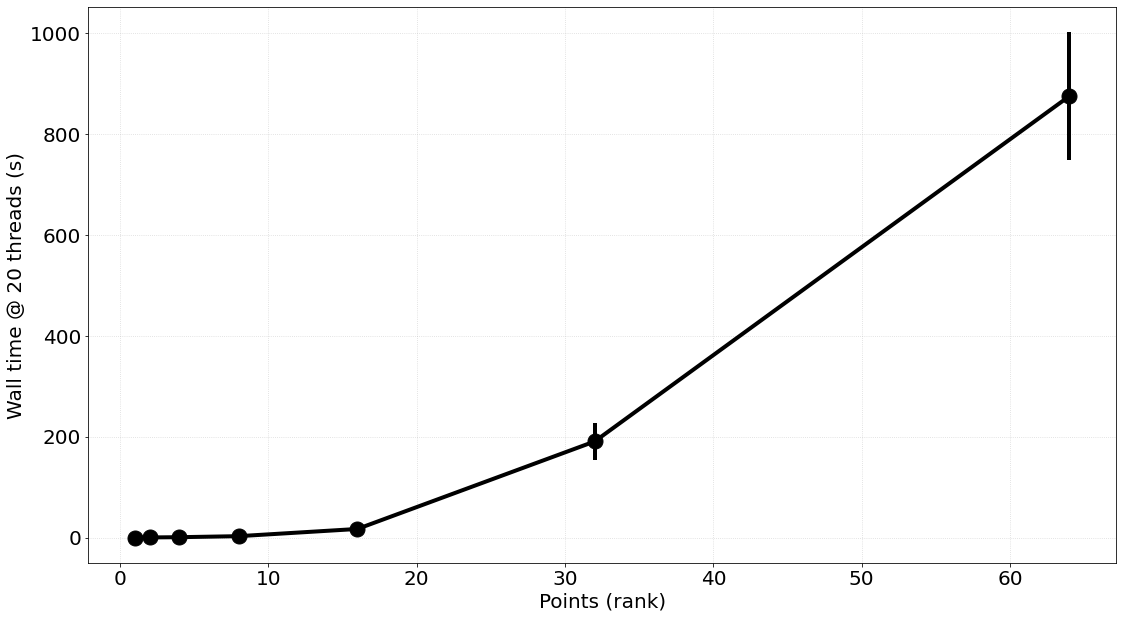

In [23]:
import matplotlib, numpy
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(16, 9)})

performance = {}
performance[1] = [0.168, 0.139, 0.098]
performance[2] = [0.321, 0.268, 0.335]
performance[4] = [0.695, 0.556, 1.12]
performance[8] = [2.72, 1.27, 4.52]
performance[16] = [24.2, 14.8, 12.3]
performance[32] = [2*60+20, 3*60+25, 3*60+47]
performance[64] = [12*60+30, 13*60+47, 17*60+29]

points = [element for element in performance.keys()]
points.sort()
means = [numpy.mean(performance[point]) for point in points]
standard_deviations = [numpy.std(performance[point]) for point in points]

matplotlib.pyplot.errorbar(points, means, yerr=standard_deviations, color='black', lw=4)
matplotlib.pyplot.plot(points, means, 'o', color='black', ms=15)
matplotlib.pyplot.xlabel('Points (rank)')
matplotlib.pyplot.ylabel('Wall time @ 20 threads (s)')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

# It seems that 128 points may take ~ 1 hour.

In [24]:
print(stat_ecoli_large)

optimal


### Run the elementary flux mode (EFM) enumeration:

In [25]:
rev = [0]*model_dict_ecoli['A'].shape[1]
reactions = model_dict_ecoli['rxns']
metabolites = model_dict_ecoli['mets']
efms_ecoli_red = efmtool.calculate_efms(model_dict_ecoli['A'],rev,reactions,metabolites)
efms_ecoli_red = remove_futile_cycles(model_dict_ecoli['A'],efms_ecoli_red)
print('Number of reduced E.coli model EFMs: ',efms_ecoli_red.shape[1])

Number of reduced E.coli model EFMs:  37
